In [1]:
from tqdm.notebook import trange
import pathlib
import numpy as np

In [2]:
rng = np.random.default_rng() #Random number generator that outputs uniformly distributed floats in the range [0,1)

<h1>Assignment 2:</h1>

<h2>Simulation:</h2>

<h3>Calculating the parameters:</h3>

The Hamiltonian is given by $$H = -J \sum_{\left\langle ij \right\rangle}{s_i s_j}$$ where $s_i \in \{+1,-1\}$.

We need to find a suitable value of $J$ such that the critical temperature $T_c$ as given by the mean field theory approximation is $2$. The relation between $J$ and $T_c$ in the mean field theory approximation is given as $JC\beta_c = \frac{JC}{kT_c}=1$ where $C=4$ for the 2D Ising model. We will define our units such that $k=2$. This conveniently gives us $J=1$.

We will consider periodic boundary conditions.

<h3>Monte-Carlo step:</h3>

The spin-up state is taken as $+1$ and the spin-down state is taken as $-1$.

In one Monte-Carlo step, we flip the state of one spin and calculate the resulting energy difference $\Delta E = E_f - E_i$. When a spin is flipped, only $4$ terms are affected in the Hamiltonian, and they are the interactions between the nearest neighbour spins of the flipped spin and the flipped spin itself. So, instead of recalculating the entire Hamiltonian every time, we can simply calculate the energy difference from these $4$ terms.

Let us say spin $s_{(i,j)}$ was flipped (which is the spin at row $i$ and column $j$). The energy difference is then $$\Delta E = 2Js_{(i,j)} \cdot \left( s_{(i+1,j)} + s_{(i,j+1)} + s_{(i-1,j)} + s_{(i,j-1)} \right)$$ since we just flipped the sign of these $4$ terms. Note that the indices are considered modulo $N$ because of periodic boundary conditions.

Then we can test if the new state satisfies our conditions and if it does, we'll flip the spin.

<h3>Speeding up the simulation:</h3>

If we consider the lattices for fixed $N$, in each timestep we are performing basically the same operation on all of them, and each step follows the same sequence of spins. So instead of evolving them one by one, we can process all of them at the same time. NumPy does this effectively through "vectorization". In the following code, I have used this idea. Instead of passing one lattice-temperature pair, I have passed lists of lattice-temperature pairs. Now, in each step, I can calculate $\Delta E$, whether the state was accepted, and flipping the spin if the state was accepted, for all of the lattices in one go. The resulting speedup is huge, I estimate about $10$ times faster.

We have to keep $N$ fixed, otherwise the array indexing would get messed up when calculating $\Delta E$.

We can make further optimisations. There is a $2$ in the energy difference formula and we also defined $k=2$. These can be cancelled to remove two multiplications. Also, division is much slower than multiplication, so we can calculate $\frac{1}{T}$ beforehand and multiply by it instead of dividing in every step.

In [27]:
def mc_step(lattices,inv_Ts,N,i,j):
    #Calculate del_E
    del_Es = lattices[:,i,j]*(lattices[:,i-1,j]+lattices[:,i+1-N,j]+lattices[:,i,j-1]+lattices[:,i,j+1-N])
    #Check if state is accepted
    rejects = rng.random(inv_Ts.shape[0]) - np.exp(-del_Es*inv_Ts)
    #Flip if accepted
    #Reject value is + or -, so map +ve -> 1 (no flip) and -ve -> -1 (flip)
    lattices[:,i,j] *= np.sign(rejects).astype(np.int8)

In [29]:
def mc_timestep(lattices,inv_Ts,N):
    #Run one step for each spin in the lattice
    for i in range(N):
        for j in range(N):
            mc_step(lattices,inv_Ts,N,i,j)

<h3>Simulating and gathering snapshots:</h3>

The following cells define the required elements of the simulation and then we run it. We take an $N \times N$ sized lattice at temperature $T$. For the initial state, we'll consider all spins to point up. First it is allowed to equilibriate for ```t_equilibrium``` timesteps, then ```snapshot_count``` snapshots are gathered every ```snapshot_interval``` timesteps.

Then the snapshots are stored in CSV format for further analysis. This way, we have to run the simulation just once, and later we can use the stored data anytime.

In [30]:
def simulate(N,Ts):
    #Create lattices
    lattices = np.ones(shape=(Ts.shape[0],N,N),dtype=np.int8)

    #Calculate inverse temperatures
    inv_Ts = 1/Ts

    #Allow lattices to equilibriate
    for t in trange(t_equilibrium,desc='Equilibriation'):
        mc_timestep(lattices,inv_Ts,N)

    #Collect snapshots
    snapshots = np.empty((snapshot_count,*lattices.shape),dtype=np.int8)
    for i in trange(snapshot_count,desc='Collecting snapshots'):
        for t in range(snapshot_interval):
            mc_timestep(lattices,inv_Ts,N)
        snapshots[i] = lattices

    #Create data directory
    pathlib.Path(f'./data/{N}/').mkdir(parents=True,exist_ok=True)

    #Store snapshots as CSV
    for i in range(Ts.shape[0]):
      #Get the snapshots for fixed T
      snapshots_T = snapshots[:,i,:,:]
      #Flatten the 2D lattice into a 1D array for storing in CSV format
      snapshots_T = snapshots_T.reshape(snapshots_T.shape[0],-1)
      #Save as CSV
      np.savetxt(f'./data/{N}/{Ts[i]:.1f}.csv',snapshots_T,fmt='%d',delimiter=',')

In [2]:
#Set the parameters here
t_equilibrium = 10000 #Equilibriation time
snapshot_interval = 100 #Autocorrelation time
snapshot_count = 1000 #Number of snapshots
N = 40 #Lattice size
T_list = np.linspace(0.1,4,40) #List of temperatures to compute for

In [ ]:
#Run this cell to generate the data
print(f'Processing N = {N}...')
simulate(N,T_list)

---

In [3]:
import os
import csv
import matplotlib.pyplot as plt
import plotly.express as px

<h2>Analysis:</h2>

<h3>How the data is stored:</h3>

The snapshots for a lattice of size $N \times N$ at temperature $T$ are stored in ```./data/{N}/{T}.csv```. For example, the snapshots for a lattice of size $25 \times 25$ at temperature $1.2$ are stored in ```./data/25/1.2.csv```. The snapshots are stored as a 2D array. Each entry of this 2D array is a snapshot of the lattice that has been flattened to a 1D array in [row-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order). It can be restored to a 2D array using [np.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

<h3>Magnetisation:</h3>

In [4]:
def get_magnetisation(data_dir,N,snapshot_count):  
    directory = data_dir + f'{N}/'
    
    magnetisation = np.empty_like(T_list)
    file_count = 0
    
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        filepath = os.path.join(directory,filename)
        if filename.endswith('.csv'):
            #Get the T value
            temp = float(filename[:-4])
        
            with open(filepath) as cfile:
                csv_reader = csv.reader(cfile, delimiter=',')
                line_count = 0
        
                mag_config = np.zeros(snapshot_count)
                #For each snapshot
                for row in csv_reader:
                    #You get the snapshot as a NxN sized 1D array
                    #You can restore it as an NxN 2D matrix using np.reshape
                    nprow = np.array(row,dtype=np.float32)
                    mag_config[line_count] = np.mean(nprow)
                    line_count += 1
                magnetisation[file_count] = np.mean(np.abs(mag_config))
                file_count += 1
    return magnetisation

In [5]:
def get_mag(filename,N,snapshot_count,T_count):
    temps = np.load(filename)
    magnetisation = np.zeros(T_count)
    temp_count = 0
    for _,temp in temps.items():
        mag_config = np.zeros(snapshot_count)
        snap_count = 0
        for snap in temp:
            mag_config[snap_count] = np.mean(snap)
            snap_count += 1
        magnetisation[temp_count] = np.mean(np.abs(mag_config))
        temp_count += 1
    return magnetisation

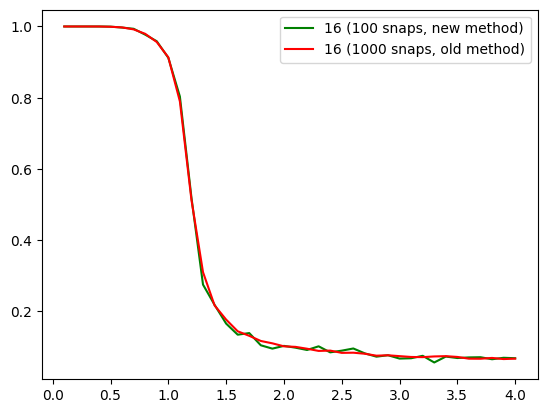

In [6]:
magnetisation_dummy_16 = get_mag('data_16_100_snaps.npz',16,100,40)
directory = f'./data/'
magnetisation_16 = get_magnetisation(directory,16,1000)
plt.plot(T_list,magnetisation_dummy_16,c='green',label='16 (100 snaps, new method)')
plt.plot(T_list,magnetisation_16,c='red',label='16 (1000 snaps, old method)')
plt.legend()
plt.show()

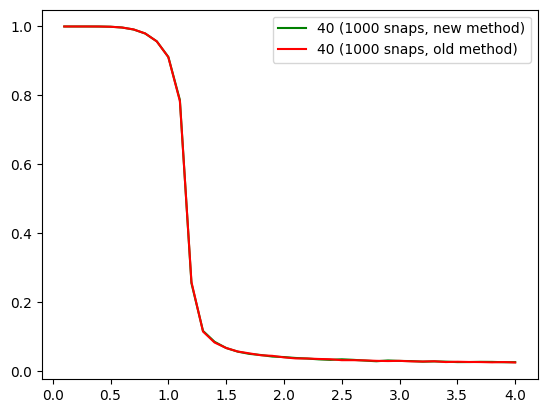

In [8]:
magnetisation_dummy_40 = get_mag('data_40.npz',40,1000,40)
directory = f'./data/'
magnetisation_40 = get_magnetisation(directory,40,1000)
plt.plot(T_list,magnetisation_dummy_40,c='green',label='40 (1000 snaps, new method)')
plt.plot(T_list,magnetisation_40,c='red',label='40 (1000 snaps, old method)')
plt.legend()
plt.show()

In [9]:
directory = f'./data/'
magnetisation_16 = get_magnetisation(directory,16,1000)
magnetisation_25 = get_magnetisation(directory,25,1000)
magnetisation_40 = get_magnetisation(directory,40,1000)

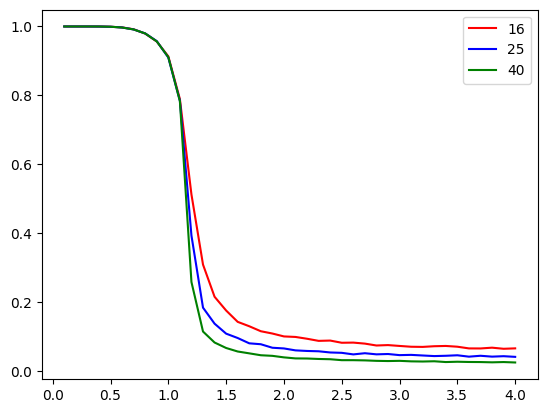

In [10]:
plt.plot(T_list,magnetisation_16,c='red',label='16')
plt.plot(T_list,magnetisation_25,c='blue',label='25')
plt.plot(T_list,magnetisation_40,c='green',label='40')
plt.legend()
plt.show()

In [11]:
magnetisation_16_new = get_mag('data_16.npz',40,1000,40)
magnetisation_40_new = get_mag('data_40.npz',40,1000,40)

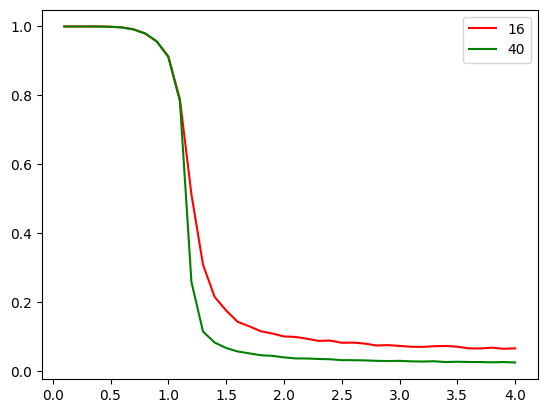

In [12]:
plt.plot(T_list,magnetisation_16,c='red',label='16')
# plt.plot(T_list,magnetisation_25,c='blue',label='25')
plt.plot(T_list,magnetisation_40,c='green',label='40')
plt.legend()
plt.show()